In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

     |████████████████████████████████| 348.9MB 58kB/s 
     |████████████████████████████████| 501kB 48.6MB/s 
     |████████████████████████████████| 3.1MB 56.0MB/s 


49152/45612 [================================] - 0s 0us/step


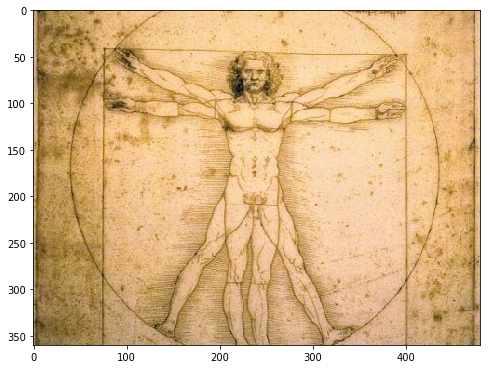

In [0]:
url = 'https://www.delltechnologies.com/uploads/2017/10/davinci_inset-480x360.jpg'
# Download an image and read it into a NumPy array.
def download(url):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = tf.keras.preprocessing.image.load_img(image_path)
  return img

# Normalize an image
def deprocess(img):
  return (img + 1.0)/2.0

original_img = download(url)
plt.imshow(original_img)

In [0]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Maximize the activations of these arbitarily chosen layers
names = ['mixed2', 'mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create our feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)



87916544/87910968 [==============================] - 8s 0us/step


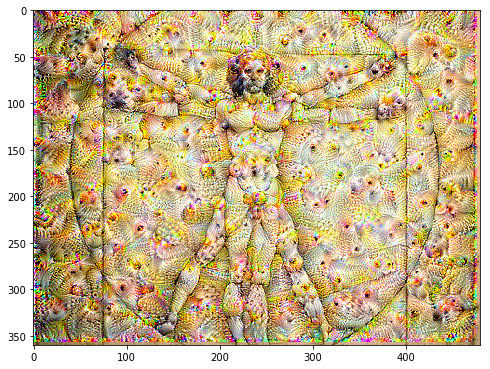

In [0]:
def calc_loss(image):
  image = image[None, ...]
  layer_activations = dream_model(image)

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
  total_loss = tf.add_n(losses)
  return total_loss

img = tf.keras.preprocessing.image.img_to_array(original_img)
img = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(img))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

@tf.function
def deepdream():
  with tf.GradientTape() as tape:
    loss = -calc_loss(img)
  gradient = tape.gradient(loss, img)

  optimizer.apply_gradients([(gradient, img)])
  img.assign(tf.clip_by_value(img, -1, 1))
  return loss

STEPS = 500
for step in range(STEPS):
  loss = deepdream()
  if step % 50 == 0:
    clear_output(wait=True)
    plt.imshow(deprocess(img))
    plt.show()
    print ('Step %d, loss %f' % (step, -1.0*loss))
clear_output()
plt.imshow(deprocess(img))